In [1]:
import pywt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data/training/a_data.csv')
labels = pd.read_csv('data/training/a_labels.csv')

In [7]:
print(repr(labels['Timestamp'][0]))
print(repr(data['Timestamp'][0]))

1489016399.0
1489016347.6607802


In [10]:
data['TimestampToSec'] = data['Timestamp'].astype(int)
grouped = data.groupby('TimestampToSec')
#np.zeros(len(labels), )

In [19]:
# for every label, look up the corresponding data

for l in labels:
    time = labels['Timestamp']
    slice = grouped.get_group(time)

grouped.get_group(1489016348)

,Id,Timestamp,Ch0,Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7,TimestampToSec
82,83,1.489016e+09,-433,-343,689,349,449,624,447,-73,1489016348
83,84,1.489016e+09,-418,-333,687,337,441,595,406,46,1489016348
84,85,1.489016e+09,-437,-339,703,353,440,609,407,61,1489016348
85,86,1.489016e+09,-468,-355,709,363,441,617,411,-274,1489016348
86,87,1.489016e+09,-442,-364,701,358,441,628,433,223,1489016348
87,88,1.489016e+09,-428,-357,687,347,453,640,456,419,1489016348
88,89,1.489016e+09,-412,-358,689,341,459,647,450,-168,1489016348
89,90,1.489016e+09,-425,-364,707,366,463,645,434,477,1489016348
90,91,1.489016e+09,-444,-365,712,374,461,641,427,495,1489016348
91,92,1.489016e+09,-441,-370,701,363,449,637,431,565,1489016348


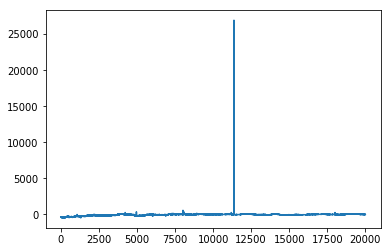

In [6]:
plt.plot(data[0:20000]['Ch0'])
plt.show()